# *22년 01월 18일 프로그래밍 세미나
# ** 발표자: 황우영

###Sequence to Sequence 네트워크를 이용한 번역
신경망이 영어를 한국어로 번역

*   하나의 시퀀스를 다른 시퀀스로 바꾸는 두개의 RNN 이 함께 동작하는 sequence to sequence network 


*   인코더 네트워크는 입력 시퀀스를 벡터로 압축하고, 디코더 네트워크는 해당 벡터를 새로운 시퀀스로 펼침



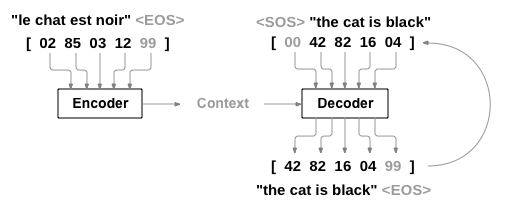



###요구 사항

In [66]:
import random
import torch
import torch.nn as nn
from torch import optim

#random seed를 고정한다는 말은 동일한 셋트의 난수를 생성
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     #gpu



*   언어의 각 단어들은 one-hot 벡터 또는 그 단어의 주소에만 단 하나의 1을 제외하고 모두 0인 벡터로 표현
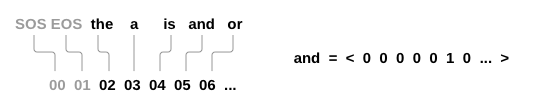



#Seq2Seq 모델

*   인코더 및 디코더라고하는 두 개의 RNN으로 구성된 모델
*   "I feel hungry. -->	나는 배가 고프다."를 번역








###manual 데이터 선언 & 전처리

In [67]:
# 데이터를 직접 선언한 경우 --> 영어 tab 한국어 구조
raw = ["I feel hungry.	나는 배가 고프다."]
       
# fix token for "start of sentence" and "end of sentence"
# decoder의 마지막 출력물을 받아오고 첫번째 step의 index를 받아온다.
SOS_token = 0 
EOS_token = 1 # 문장의 종료를 알려주는 것

# declare max length for sentence
SOURCE_MAX_LENGTH = 10
TARGET_MAX_LENGTH = 12

In [68]:
# 데이터 단어 관련 class
class Vocab:
    def __init__(self):
        self.vocab2index = {"<SOS>": SOS_token, "<EOS>": EOS_token}
        self.index2vocab = {SOS_token: "<SOS>", EOS_token: "<EOS>"}
        self.vocab_count = {}
        self.n_vocab = len(self.vocab2index)

    def add_vocab(self, sentence):
        for word in sentence.split(" "):
            if word not in self.vocab2index:
                self.vocab2index[word] = self.n_vocab
                self.vocab_count[word] = 1
                self.index2vocab[self.n_vocab] = word
                self.n_vocab += 1
            else:
                self.vocab_count[word] += 1

In [69]:
# corpous 데이터 읽고 전처리
def preprocess(corpus, source_max_length, target_max_length):
    print("reading corpus...")
    pairs = []
    for line in corpus:
        pairs.append([s for s in line.strip().lower().split("\t")])
    print("Read {} sentence pairs".format(len(pairs)))

    source_vocab = Vocab()
    target_vocab = Vocab()

    print("Counting words...")
    for pair in pairs:
        source_vocab.add_vocab(pair[0])
        target_vocab.add_vocab(pair[1])
    print("source vocab size =", source_vocab.n_vocab)
    print("target vocab size =", target_vocab.n_vocab)

    return pairs, source_vocab, target_vocab

###인코더

*   seq2seq 네트워크의 인코더는 입력 문장의 모든 단어에 대해 어떤 값을 출력하는 RNN

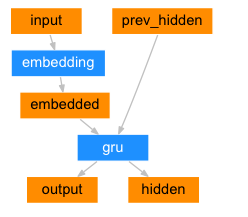




In [70]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.rnn(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

nn.Embedding()
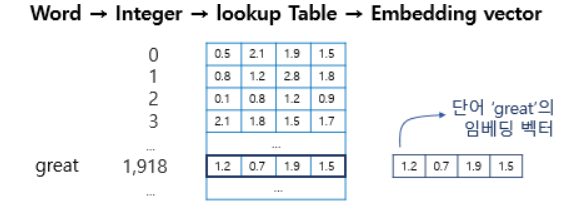

###디코더
*   디코더는 인코더 출력 벡터를 받아서 번역을 생성하는 단어 시퀀스를 출력

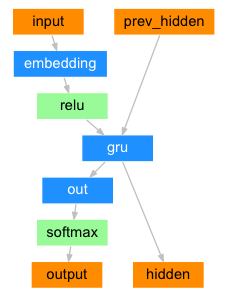


In [71]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU()

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = self.relu(output)
        output, hidden = self.rnn(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

###학습 function

In [72]:
# 문장을 index tensor로 변환
def tensorize(vocab, sentence):
    indexes = [vocab.vocab2index[word] for word in sentence.split(" ")]
    indexes.append(vocab.vocab2index["<EOS>"])
    return torch.Tensor(indexes).long().to(device).view(-1, 1)

In [73]:
# training seq2seq
def train(pairs, source_vocab, target_vocab, encoder, decoder, n_iter, print_every=1000, learning_rate=0.01):
    loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_batch = [random.choice(pairs) for _ in range(n_iter)]
    training_source = [tensorize(source_vocab, pair[0]) for pair in training_batch]
    training_target = [tensorize(target_vocab, pair[1]) for pair in training_batch]

    criterion = nn.NLLLoss()

    for i in range(1, n_iter + 1):
        source_tensor = training_source[i - 1]
        target_tensor = training_target[i - 1]

        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        source_length = source_tensor.size(0)
        target_length = target_tensor.size(0)

        loss = 0

        for enc_input in range(source_length):
            _, encoder_hidden = encoder(source_tensor[enc_input], encoder_hidden)

        decoder_input = torch.Tensor([[SOS_token]]).long().to(device)
        decoder_hidden = encoder_hidden # connect encoder output to decoder input

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # teacher forcing

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        loss_iter = loss.item() / target_length
        loss_total += loss_iter

        if i % print_every == 0:
            loss_avg = loss_total / print_every
            loss_total = 0
            print("[{} - {}%] loss = {:05.4f}".format(i, i / n_iter * 100, loss_avg))

###각 class 초기화

In [74]:
# preprocess the corpus
load_pairs, load_source_vocab, load_target_vocab = preprocess(raw, SOURCE_MAX_LENGTH, TARGET_MAX_LENGTH)
print(random.choice(load_pairs))

reading corpus...
Read 1 sentence pairs
Counting words...
source vocab size = 5
target vocab size = 5
['i feel hungry.', '나는 배가 고프다.']


In [75]:
print(load_pairs)
print(load_source_vocab.vocab2index)
print(load_target_vocab.index2vocab)

[['i feel hungry.', '나는 배가 고프다.']]
{'<SOS>': 0, '<EOS>': 1, 'i': 2, 'feel': 3, 'hungry.': 4}
{0: '<SOS>', 1: '<EOS>', 2: '나는', 3: '배가', 4: '고프다.'}


In [76]:
# declare the encoder and the decoder
enc_hidden_size = 16
dec_hidden_size = enc_hidden_size
enc = EncoderRNN(load_source_vocab.n_vocab, enc_hidden_size).to(device)
dec = DecoderRNN(dec_hidden_size, load_target_vocab.n_vocab).to(device)

###학습

In [77]:
# train seq2seq model
train(load_pairs, load_source_vocab, load_target_vocab, enc, dec, 5000, print_every=1000)

[1000 - 20.0%] loss = 0.0729
[2000 - 40.0%] loss = 0.0039
[3000 - 60.0%] loss = 0.0022
[4000 - 80.0%] loss = 0.0015
[5000 - 100.0%] loss = 0.0012


###번역

In [78]:
# insert given sentence to check the training
def evaluate(pairs, source_vocab, target_vocab, encoder, decoder, target_max_length):
    for pair in pairs:
        print(">", pair[0])
        print("=", pair[1])
        source_tensor = tensorize(source_vocab, pair[0])
        source_length = source_tensor.size()[0]
        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)

        for ei in range(source_length):
            _, encoder_hidden = encoder(source_tensor[ei], encoder_hidden)

        decoder_input = torch.Tensor([[SOS_token]], device=device).long()
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(target_max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, top_index = decoder_output.data.topk(1)
            if top_index.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(target_vocab.index2vocab[top_index.item()])

            decoder_input = top_index.squeeze().detach()

        predict_words = decoded_words
        predict_sentence = " ".join(predict_words)
        print("<", predict_sentence)
        print("")

In [79]:
# check the model with given data
evaluate(load_pairs, load_source_vocab, load_target_vocab, enc, dec, TARGET_MAX_LENGTH)

> i feel hungry.
= 나는 배가 고프다.
< 나는 배가 고프다. <EOS>

